In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  !git clone https://github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [3]:
#@title Setup environment and Colab general variables { display-mode: "form" }
# %%capture
%run colab_setup.ipynb

In [4]:
#@title Move images from Drive to temporary folder here to be able to train models
# %%capture
%run move_raw_preprocess.ipynb

In [5]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fastai.basics import *
from fastai.callback.all import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.vision import models
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW
from fastai.vision.data import *
from fastai.vision.learner import create_cnn_model

In [12]:
from semisupervised.fixmatch.losses import FixMatchLoss
from semisupervised.fixmatch.callback import FixMatchCallback
from semisupervised.utils import TestColSplitter

# Required to load DICOM on the fly
from preprocessing import PILDicom_scaled, init_bins, HistScaled, HistScaled_all

In [7]:
TEST_SIZE = 0.15
VALID_SIZE = 0.15

In [42]:
# Hyperparameters

HIST_SCALED = False

LR = 0.002
MOMENTUM = 0.9

BATCH_SIZE = 8
RESIZE = 512
RANDOM_RESIZE_CROP = 256

MU = 7
LABEL_THRESHOLD = 0.95

LAMBDA_U = 1
# EMA_DECAY = 0.999

MODEL = models.resnet18

In [9]:
# Transformations

item_tfms = [
    Resize(RESIZE, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # RandomResizedCrop(RANDOM_RESIZE_CROP),
]

label_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Normalize()
]

class Multiply_255(Transform):
    def encodes(self, o): return o * 255

weak_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    # Multiply_255(),
    # Normalize()
]

strong_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Rotate(90),
    Brightness(),
    Contrast(),
    RandomErasing(),
    # Multiply_255(),
    # Normalize()
]

In [56]:
# Callbacks
from fastai.callback.tensorboard import TensorBoardCallback

cbs = None
cbs = [
    TensorBoardCallback(),
    MixUp,
]

In [16]:
# Data
df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

relation_df = pd.read_csv(os.path.join(PATH_PREFIX, 'relation_local.csv'))
relation_df = relation_df.set_index('Filename')

final_df = df.set_index('ID').merge(relation_df, left_index=True, right_index=True)
final_df['ID'] = final_df.index.values
final_df = final_df.reset_index(drop=True)
final_df['Raw_preprocess'] = final_df['Original_Filename'].apply(lambda filename: os.path.join(raw_preprocess_folder, filename + '.png'))

unlabel_df = final_df[df['Target'].isnull()].reset_index(drop=True)
label_df = final_df[df['Target'].notnull()].reset_index(drop=True)

train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, stratify=label_df['Target'])
train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, stratify=train_df['Target'])

label_df.loc[train_df.index, 'Dataset'] = 'train'
label_df.loc[val_df.index, 'Dataset'] = 'valid'
label_df.loc[test_df.index, 'Dataset'] = 'test'

In [43]:
# Histogram scaling DICOM on the fly

if HIST_SCALED:
    # bins = init_bins(fnames=L(list(final_df['Original'].values)), n_samples=100)
    bins = init_bins(fnames=L(list(final_df['Raw_preprocess'].values)), n_samples=100, isDCM=False)
    # item_tfms.append(HistScaled(bins))
    item_tfms.append(HistScaled_all(bins))

In [58]:
# DataLoaders
print(f'==> Preparing label dataloaders')

label_dl = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('Original_Filename', pref=raw_preprocess_folder+'/', suff='.png'),
    # blocks=(ImageBlock(cls=PILDicom_scaled), MultiCategoryBlock),
    # get_x=ColReader('Original'),
    get_y=ColReader('Target'),
    splitter=TestColSplitter(col='Dataset'),
    item_tfms=item_tfms,
    batch_tfms=label_transform,
).dataloaders(label_df, bs=BATCH_SIZE, num_workers=0, shuffle_train=True, drop_last=True)

print(f'==> Preparing unlabel dataloaders')

ds_params = {
    'blocks': (ImageBlock(cls=PILImageBW)),
    'get_x': ColReader('Original_Filename', pref=raw_preprocess_folder+'/', suff='.png'),
    # 'blocks': (ImageBlock(cls=PILDicom_scaled)),
    # 'get_x': ColReader('Original'),
    'splitter': RandomSplitter(0),
    'item_tfms': item_tfms
}
dls_params = {
    'source': unlabel_df,
    'bs': BATCH_SIZE * MU,
    'num_workers': 0,
    'shuffle_train': True,
    'drop_last': True
}

unlabel_dl = DataBlock(
    **ds_params
).dataloaders(**dls_params)

weak_transform_dl = DataBlock(
    **ds_params,
    batch_tfms = weak_transform
).dataloaders(**dls_params)

strong_transform_dl = DataBlock(
    **ds_params,
    batch_tfms = strong_transform
).dataloaders(**dls_params)

print(f'==> Preparing MixMatch callback')

fix_match_cb = FixMatchCallback(unlabel_dl, weak_transform_dl, strong_transform_dl)
if cbs is None:
    cbs = [fix_match_cb]
else:
    cbs.append(fix_match_cb)

==> Preparing label dataloaders
==> Preparing unlabel dataloaders
==> Preparing MixMatch callback


In [59]:
# Scheduling
sched = {'lr': SchedCos(LR, LR*math.cos(7*math.pi/16))}
cbs.append(ParamScheduler(sched))
moms = (MOMENTUM) # 0.9 according to FixMatch paper

In [60]:
# Model
print("==> creating model")

def create_model(model_arq, n_out, pretrained=True, n_in=1, ema=False):
    model = create_cnn_model(model_arq, n_out=n_out, cut=None, pretrained=pretrained, n_in=n_in)
    model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

classes = label_df['Target'].unique()
n_out = len(classes)

model = create_model(MODEL, n_out, pretrained=True, n_in=1)
# ema_model = create_model(MODEL, n_out, pretrained=True, n_in=1, ema=True)

==> creating model


In [61]:
# Loss
print("==> defining loss")

class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['Target'])
class_weight = torch.as_tensor(class_weight).float()
if torch.cuda.is_available():
    class_weight = class_weight.cuda()

train_criterion = FixMatchLoss(unlabel_dl=unlabel_dl, n_out=n_out, bs=BATCH_SIZE, mu=MU, lambda_u=LAMBDA_U, label_threshold=LABEL_THRESHOLD, weight=class_weight)
criterion = train_criterion.Lx_criterion

==> defining loss


In [62]:
# Learner
print("==> defining learner")

Lx_metric = AvgMetric(func=criterion)
Lu_metric = AvgMetric(func=train_criterion.Lu_criterion)

f1_score = F1ScoreMulti(average='macro')
precision = PrecisionMulti(average='macro')
recall = RecallMulti(average='macro')
fastai_metrics = [
    # Lx_metric, Lu_metric, 
    f1_score,
    precision, recall
]

learn = Learner(label_dl, model, loss_func=train_criterion, opt_func=SGD, lr=LR, metrics=fastai_metrics, cbs=cbs)

# learn.fine_tune(1)
learn.fit(2)

==> defining learner
epoch     train_loss  valid_loss  f1_score  precision_score  recall_score  time    
0         5.106869    6.203327    0.495652  0.491379         0.500000      01:32     
1         5.188201    5.924100    0.495652  0.491379         0.500000      01:32     


,target,predicted,probabilities,loss
0,3,,"tensor([ 27.1448, -30.9097])",3846.114990234375
1,0,,"tensor([ 23.7191, -26.7462])",0.0
2,0,,"tensor([ 26.9680, -32.3374])",0.0
3,0,,"tensor([ 23.0224, -25.7910])",0.0
4,0,,"tensor([ 27.7153, -31.1412])",0.0
5,0,,"tensor([ 25.9261, -29.6912])",0.0
6,0,,"tensor([ 33.3838, -40.1495])",0.0
7,0,,"tensor([ 24.6545, -29.4178])",0.0


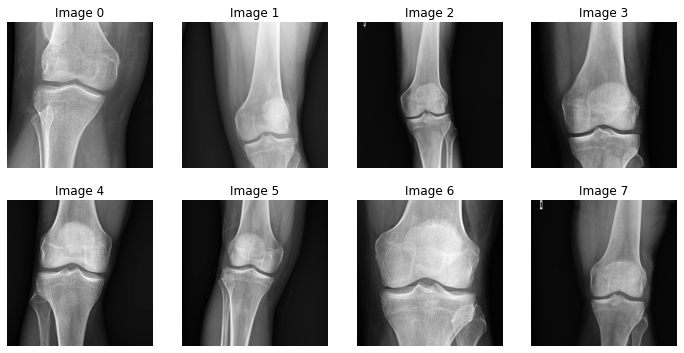

In [15]:
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn, ds_idx=1)
interp.plot_top_losses(k=8)